In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

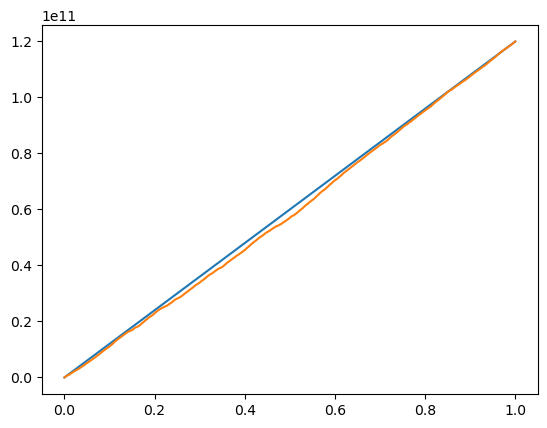

In [8]:
filename = r"J:\ctgroup\Edward\DATA\VMI\20240730\firstNanoData_08_000000.h5"

with h5py.File(filename, 'r') as f:
    data={}
    for k in f.keys():
        data[k] = f[k][()]
        
tdc_time=data['tdc_time']
tdc_type=data['tdc_type']

tdc1_start_idx= np.argwhere(tdc_type==1).flatten()
tdc1_end_idx=np.argwhere(tdc_type==2).flatten()

tdc1_time=tdc_time[tdc1_start_idx]
tdc1_length=tdc_time[tdc1_end_idx]-tdc_time[tdc1_start_idx]

laser_times=np.unwrap(tdc1_time[tdc1_length>500],period=25*2**30)
ion_times=np.unwrap(tdc1_time[tdc1_length<500],period=25*2**30)

plt.plot(np.linspace(0,1,num=len(laser_times)),laser_times)
plt.plot(np.linspace(0,1,num=len(ion_times)),ion_times)

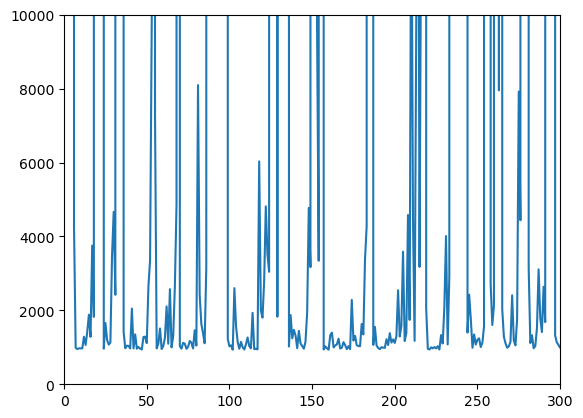

In [9]:
candidates=ion_times[np.argwhere(np.diff(ion_times)<5000)].flatten()
plt.plot(np.diff(candidates))
plt.ylim(0,10000)
plt.xlim(0,300)

current_candidate=0
np_hits=[]
hit_count=1
hit_counts=[]
for candidate in candidates:
    if candidate-current_candidate<10000*hit_count:
        hit_count+=1
    else:
        if hit_count>1:
            np_hits.append(current_candidate)
            hit_counts.append(hit_count)
            hit_count=1
        current_candidate=candidate



Text(0, 0.5, 'Trigger Voltage (V)')

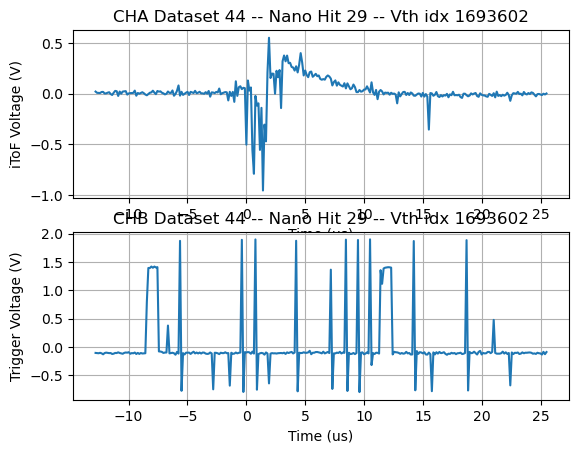

In [10]:

# Function Definitions
def adc2mV(intADC, range_idx, maxADC):
    channel_input_ranges = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
    vRange = channel_input_ranges[range_idx]
    mV = (intADC.astype(float) * vRange) / maxADC
    return mV

def get_sampling_interval(res, timebase):
    if res == 8:
        if -1 < timebase < 3:
            return (2 ** timebase) / 1e9
        elif timebase > 2:
            return (timebase - 2) / 125e6
    elif res == 12:
        if 0 < timebase < 3:
            return (2 ** (timebase - 1)) / 500e6
        elif timebase > 2:
            return (timebase - 3) / 62.5e6
    elif res in [14, 15]:
        if timebase == 3:
            return 1 / 125e6
        elif timebase > 3:
            return (timebase - 2) / 125e6
    elif res == 16:
        if timebase == 4:
            return 1 / 62.5e6
        elif timebase > 4:
            return (timebase - 3) / 62.5e6
    return -1

def get_bit_depth(resolution):
    bit_depth_lst = [8, 12, 14, 15, 16, 10]
    return bit_depth_lst[resolution]

def get_last_dataset_number(file):
    with h5py.File(file, 'r') as f:
        max_dataset = 0
        for name in f.keys():
            if name.startswith('CH_A_'):

                num = int(name.split('_')[2])
                max_dataset = max(max_dataset, num)
    return max_dataset


# Params
file = r"J:\ctgroup\Edward\DATA\VMI\20240730\firstNanoData_Vth800mV_real.h5"
Vth = -0.3
saBeyondThresh = 200
saLookForward = 200
bgThresh = 0.1
saAboveBg = 15
pltTraces = False

# Grab Sampling Properties
with h5py.File(file, 'r') as f:
    SI = f['/SI'][()]
    DSI = f['/DSI'][()]
    res = get_bit_depth(f['/Resolution'][()])
    vriA = f['/VoltRngIdx_CHA'][()]
    vriB = f['/VoltRngIdx_CHB'][()]
    maxADC = f['/Max_ADC_Val'][()]
    preTrigSamp = f['/PreTrigSamp'][()]
    postTrigSamp = f['/PostTrigSamp'][()]
    numSamp = int(preTrigSamp + postTrigSamp)

# Process Data
false_positive = 0
nano_hit = 0

hits=[]
for i in range(1, get_last_dataset_number(file) + 1):
    trace_str = f'{i:010d}'
    pathA = f'/CH_A_{trace_str}'
    pathB = f'/CH_B_{trace_str}'
    path_timestamp = f'/DatTimestamp_{trace_str}'
    path_epochSA = f'/EpochSA_{trace_str}'

    with h5py.File(file, 'r') as f:
        Va = adc2mV(f[pathA][()], vriA, maxADC) / 1000
        Vb = adc2mV(f[pathB][()], vriB, maxADC) / 1000
        trace_timestamp = f[path_timestamp][()]
        epoch_sa_before_trace = f[path_epochSA][()]
        t = np.arange(len(Va)) * DSI

    idxs = np.where(Va < Vth)[0]
    last_idx = 0
    for idx in idxs:
        if idx > last_idx + saLookForward:
            if idx + saLookForward < len(Va):
                VaTest = Va[idx + 2: idx + saLookForward]
                VaTest = VaTest[(VaTest > bgThresh) | (VaTest < -bgThresh)]
                if len(VaTest) > saAboveBg:
                    nano_hit += 1

                    # DATA FOR EACH iToF hit + trace time_stamp from above
                    tToF = (t[idx - saBeyondThresh//2:idx + saBeyondThresh] - t[idx]) * 1E6
                    VaToF = Va[idx - saBeyondThresh//2:idx + saBeyondThresh]
                    VbToF = Vb[idx - saBeyondThresh//2:idx + saBeyondThresh]
                    epoch_sa_idx_of_vth = epoch_sa_before_trace + idx
                    
                    hits.append((tToF, VaToF, VbToF, epoch_sa_idx_of_vth))

                    if pltTraces:
                        plt.subplot(2, 1, 1)
                        plt.title(f'CHA Dataset {i} -- Nano Hit {nano_hit} -- Vth idx {idx}')
                        plt.plot(tToF, VaToF)
                        plt.ylabel("iToF Voltage (V)")
                        plt.xlabel("Time (us)")
                        plt.grid(True)

                        plt.subplot(2, 1, 2)
                        plt.title(f'CHB Dataset {i} -- Nano Hit {nano_hit} -- Vth idx {idx}')
                        plt.plot(tToF, VbToF)
                        plt.grid(True)
                        plt.xlabel("Time (us)")
                        plt.ylabel("Trigger Voltage (V)")

                        plt.show()
                else:
                    false_positive += 1
                last_idx = idx
            else:
                last_idx = idx

plt.subplot(2, 1, 1)
plt.title(f'CHA Dataset {i} -- Nano Hit {nano_hit} -- Vth idx {idx}')
plt.plot(tToF, VaToF)
plt.ylabel("iToF Voltage (V)")
plt.xlabel("Time (us)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title(f'CHB Dataset {i} -- Nano Hit {nano_hit} -- Vth idx {idx}')
plt.plot(tToF, VbToF)
plt.grid(True)
plt.xlabel("Time (us)")
plt.ylabel("Trigger Voltage (V)")

184758218.0


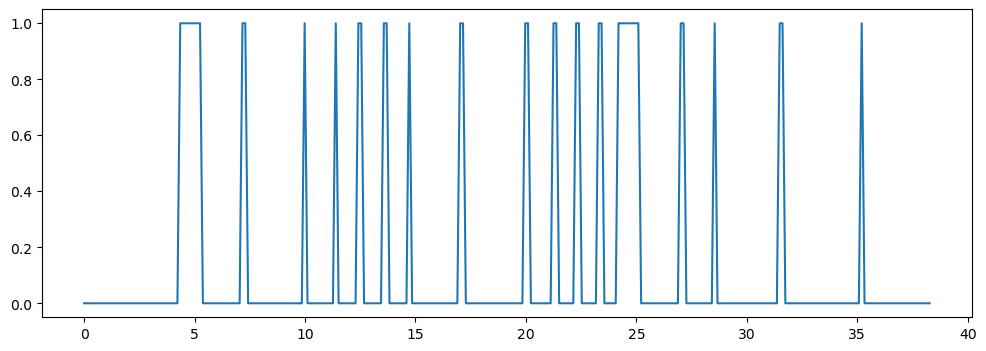

(99, 35.0, 246)


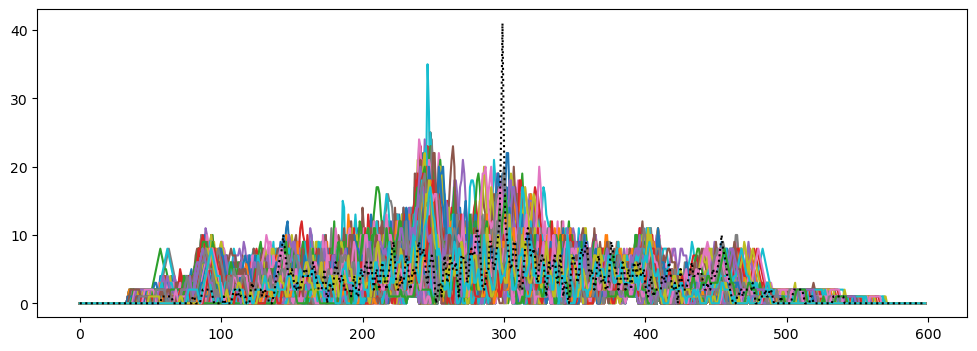

In [11]:
tToF, VaToF, VbToF, epoch_sa_idx_of_vth = hits[28]

print(epoch_sa_idx_of_vth)
measured_voltage_corr=np.where(np.logical_or(VbToF>0.5,VbToF<-0.2), 1, 0)
plt.figure(figsize=(12,4))
plt.plot(tToF-tToF[0], measured_voltage_corr)

plt.show()

current_val=(0,0,0)
plt.figure(figsize=(12,4))
for i in range(400):
    r=(np_hits[i]-12800, np_hits[i]+25472)
    itof_mask=np.argwhere((ion_times>r[0]) & (ion_times<r[1])).flatten()
    pulse_mask=np.argwhere((laser_times>r[0]) & (laser_times<r[1])).flatten()
    time=np.linspace(r[0],r[1],num=len(tToF))
    ion_dur=200
    laser_dur=1000
    volt=np.zeros_like(time)
    for j in range(0,len(itof_mask)):
        volt+= np.where((time>ion_times[itof_mask[j]]) & (time<ion_times[itof_mask[j]]+ion_dur), 1, 0)
    for j in range(0,len(pulse_mask)):
        volt+= np.where((time>laser_times[pulse_mask[j]]) & (time<laser_times[pulse_mask[j]]+laser_dur), 1, 0)
    
    time=(time-time[0])/1000
# plt.plot(time,volt)


    corr=np.correlate(measured_voltage_corr, volt, mode='full')
    if max(corr)>current_val[1]:
        current_val=(i, max(corr), np.argwhere(corr==max(corr)).flatten()[0])
        # print(current_val)
    plt.plot(corr)

plt.plot(np.correlate(measured_voltage_corr, measured_voltage_corr, mode='full'), c='k', ls=":")
print(current_val)

[[-6.78400009]]


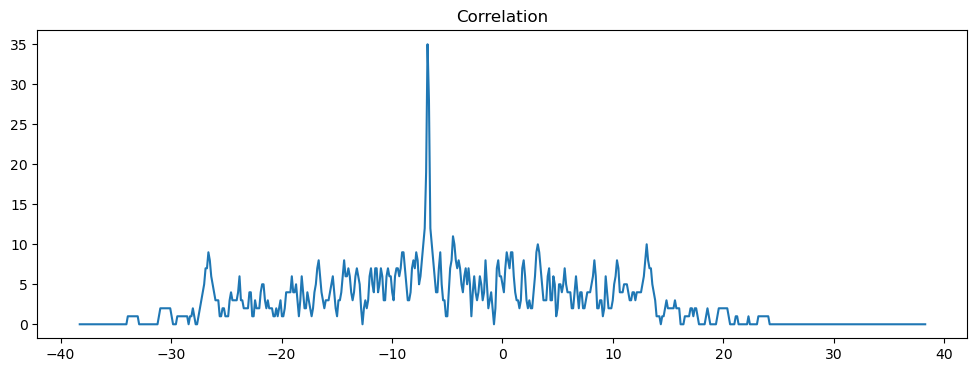

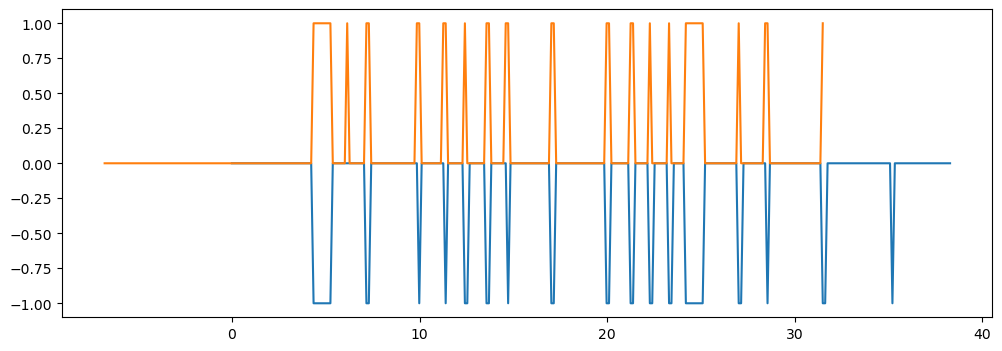

In [12]:
i=current_val[0]
r=(np_hits[i]-12800, np_hits[i]+25472)
itof_mask=np.argwhere((ion_times>r[0]) & (ion_times<r[1])).flatten()
pulse_mask=np.argwhere((laser_times>r[0]) & (laser_times<r[1])).flatten()

# plt.show()
time=np.linspace(r[0],r[1],num=len(tToF))
ion_dur=200
laser_dur=1000
volt=np.zeros_like(time)
for i in range(0,len(itof_mask)):
    volt+= np.where((time>ion_times[itof_mask[i]]) & (time<ion_times[itof_mask[i]]+ion_dur), 1, 0)
for i in range(0,len(pulse_mask)):
    volt+= np.where((time>laser_times[pulse_mask[i]]) & (time<laser_times[pulse_mask[i]]+laser_dur), 1, 0)

plt.figure(figsize=(12,4))
plt.title("Correlation")
t=tToF-tToF[0]
corr=np.correlate(measured_voltage_corr, volt, mode='full')
t_corr=np.linspace(-max(t),max(t),num=len(corr))
print(t_corr[np.argwhere(corr==max(corr))])
plt.plot(t_corr, corr)

plt.figure(figsize=(12,4))
plt.plot(t, -measured_voltage_corr)
plt.plot(t+t_corr[np.argwhere(corr==max(corr)).flatten()[0]],volt)